# Семинар. Текстовая классификация в финтех‑домена: TF/DF → TF‑IDF → Word2Vec → BERT (Jupyter/Colab-friendly)

**Сквозная цель:** взять *новый* финансовый датасет с текстом и пройти полный путь:
1) EDA → 2) базовые признаки (TF/DF, TF‑IDF) → 3) Word2Vec doc‑vectors → 4) BERT (feature‑based и fine‑tuning).

> Формат: короткие объяснения → маленькие примеры → мини‑проект с сравнением методов.

**Датасет:** *Financial PhraseBank* — предложения из финансовых новостей с меткой тональности (positive/negative/neutral).


## Пакеты (один раз фиксируем)

⚠️ Если вы в Google Colab — этот блок обычно обязателен. Если локально — возможно, всё уже стоит.


In [1]:
# === Установка зависимостей (Colab-friendly) ===
# Если вы запускаете локально и всё уже установлено — эту клетку можно пропустить/закомментировать.
!pip -q install datasets scikit-learn pandas numpy matplotlib gensim nltk transformers accelerate

import os, re, math, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

random.seed(42)
np.random.seed(42)

# (Опционально) скачиваем nltk-ресурсы для токенизации/стоп-слов
import nltk
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
vllm 0.12.0 requires torchaudio==2.9.0, which is not installed.
vllm 0.12.0 requires torchvision==0.24.0, which is not installed.
vllm 0.12.0 requires setuptools<81.0.0,>=77.0.3; python_version > "3.11", but you have setuptools 70.2.0 which is incompatible.

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


True

## 0) Загрузка датасета

Мы используем датасет **Financial PhraseBank** (Hugging Face `datasets`).
- текст: предложение из финансовых новостей
- метка: `negative / neutral / positive`

💡 Почему удобно для семинара:
- небольшой размер → всё обучается за минуты
- финансовый домен → «похоже на жизнь»
- 3 класса → легко визуализировать ошибки (confusion matrix)


In [7]:
from datasets import load_dataset

ds = load_dataset(
    "takala/financial_phrasebank",
    "sentences_allagree",
    revision="refs/pr/10", 
)
ds

Generating train split: 100%|██████████| 2264/2264 [00:00<00:00, 210165.42 examples/s]


DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2264
    })
})

In [8]:
# Превратим в pandas
df = pd.DataFrame(ds["train"])
df.rename(columns={"sentence":"text"}, inplace=True)

# У меток в датасете обычно есть ClassLabel — достанем имена
label_names = ds["train"].features["label"].names
label_names


['negative', 'neutral', 'positive']

In [9]:
df.head()


,text,label
0,"According to Gran , the company has no plans t...",1
1,"For the last quarter of 2010 , Componenta 's n...",2
2,"In the third quarter of 2010 , net sales incre...",2
3,Operating profit rose to EUR 13.1 mn from EUR ...,2
4,"Operating profit totalled EUR 21.1 mn , up fro...",2


In [10]:
# Добавим человеко‑читаемую метку
df["label_name"] = df["label"].apply(lambda i: label_names[i])
df["label_name"].value_counts()


label_name
neutral     1391
positive     570
negative     303
Name: count, dtype: int64

## 1) EDA (минимально, но полезно)

Цель EDA в NLP‑классификации:
- понять баланс классов
- понять типичные длины текстов
- увидеть «сигнальные» слова

Сделаем EDA без «тяжёлых» библиотек, чтобы было ясно, что происходит.


In [11]:
# 1.1 Баланс классов
counts = df["label_name"].value_counts().sort_index()
counts


label_name
negative     303
neutral     1391
positive     570
Name: count, dtype: int64

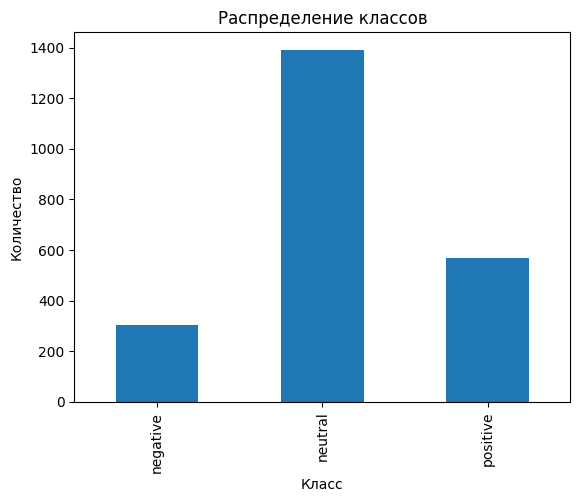

In [12]:
plt.figure()
counts.plot(kind="bar")
plt.title("Распределение классов")
plt.xlabel("Класс")
plt.ylabel("Количество")
plt.show()


In [13]:
# 1.2 Длины текстов (в словах)
def simple_tokenize(s: str):
    return re.findall(r"[A-Za-z]+(?:'[A-Za-z]+)?", str(s).lower())

df["n_words"] = df["text"].apply(lambda s: len(simple_tokenize(s)))
df[["n_words"]].describe()


,n_words
count,2264.000000
mean,18.684187
std,8.450872
min,1.000000
25%,12.000000
50%,17.000000
75%,24.000000
max,50.000000


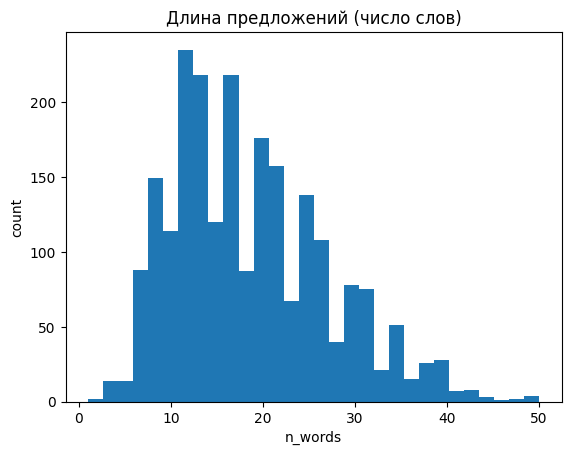

In [14]:
plt.figure()
plt.hist(df["n_words"], bins=30)
plt.title("Длина предложений (число слов)")
plt.xlabel("n_words")
plt.ylabel("count")
plt.show()


In [15]:
# 1.3 Посмотрим по классам
df.groupby("label_name")["n_words"].describe()


,count,mean,std,min,25%,50%,75%,max
label_name,,,,,,,,
negative,303.0,19.627063,8.636297,4.0,13.0,18.0,25.0,49.0
neutral,1391.0,17.922358,8.287097,1.0,12.0,17.0,23.0,50.0
positive,570.0,20.042105,8.540711,5.0,13.0,19.0,26.0,44.0


### 1.4 Топ‑слова (очень грубо)

Сейчас мы **не** делаем сложную лемматизацию — задача EDA тут не в идеальном препроцессинге, а в интуиции.

Делаем:
1) токенизация → 2) частоты → 3) топ‑20


In [16]:
from collections import Counter
from nltk.corpus import stopwords

STOP = set(stopwords.words("english"))

def top_words(texts, k=20):
    c = Counter()
    for t in texts:
        toks = [w for w in simple_tokenize(t) if w not in STOP and len(w) > 2]
        c.update(toks)
    return c.most_common(k)

print("Top words overall:")
top_words(df["text"], k=20)[:10]


Top words overall:


[('eur', 1017),
 ('company', 349),
 ('profit', 322),
 ('net', 292),
 ('million', 267),
 ('sales', 261),
 ('year', 259),
 ('finnish', 224),
 ('said', 206),
 ('operating', 202)]

In [17]:
# топ-слова по классам
for lab in sorted(df["label_name"].unique()):
    print("\n===", lab, "===")
    print(top_words(df.loc[df["label_name"]==lab, "text"], k=12))



=== negative ===
[('eur', 307), ('profit', 122), ('net', 84), ('sales', 72), ('year', 72), ('quarter', 71), ('operating', 68), ('mln', 62), ('period', 58), ('million', 57), ('finnish', 57), ('decreased', 52)]

=== neutral ===
[('company', 225), ('eur', 178), ('finland', 109), ('shares', 105), ('business', 97), ('group', 95), ('million', 92), ('services', 82), ('share', 77), ('said', 72), ('also', 63), ('market', 61)]

=== positive ===
[('eur', 532), ('profit', 172), ('net', 166), ('year', 155), ('sales', 129), ('period', 125), ('million', 118), ('finnish', 108), ('operating', 103), ('said', 100), ('mln', 99), ('quarter', 89)]


## 2) TF и DF «на пальцах»

Перед TF‑IDF важно почувствовать две базовые штуки:

- **TF (term frequency)** — «насколько часто слово встречается *в документе*»
- **DF (document frequency)** — «в скольких документах слово вообще встречается»

Дальше из TF и DF собирают **IDF** и **TF‑IDF**.


### 2.1 Игрушечный пример
Возьмём 3 мини‑документа и посчитаем TF и DF руками.


In [18]:
toy_docs = [
    "profit profit rises",
    "profit falls amid market uncertainty",
    "company reports record loss"
]

toy_tokens = [simple_tokenize(d) for d in toy_docs]
toy_tokens


[['profit', 'profit', 'rises'],
 ['profit', 'falls', 'amid', 'market', 'uncertainty'],
 ['company', 'reports', 'record', 'loss']]

In [19]:
# TF: считаем частоты в каждом документе
def tf(tokens):
    c = Counter(tokens)
    total = len(tokens)
    return {w: c[w]/total for w in c}

for i, toks in enumerate(toy_tokens, 1):
    print(f"Doc {i}: {toy_docs[i-1]}")
    print("TF:", tf(toks))
    print()


Doc 1: profit profit rises
TF: {'profit': 0.6666666666666666, 'rises': 0.3333333333333333}

Doc 2: profit falls amid market uncertainty
TF: {'profit': 0.2, 'falls': 0.2, 'amid': 0.2, 'market': 0.2, 'uncertainty': 0.2}

Doc 3: company reports record loss
TF: {'company': 0.25, 'reports': 0.25, 'record': 0.25, 'loss': 0.25}



In [20]:
# DF: в скольких документах встречается слово
def df_count(tokens_list):
    vocab = sorted(set(w for toks in tokens_list for w in set(toks)))
    out = {}
    for w in vocab:
        out[w] = sum(1 for toks in tokens_list if w in set(toks))
    return out

df_toy = df_count(toy_tokens)
df_toy


{'amid': 1,
 'company': 1,
 'falls': 1,
 'loss': 1,
 'market': 1,
 'profit': 2,
 'record': 1,
 'reports': 1,
 'rises': 1,
 'uncertainty': 1}

### 2.2 Как это делает sklearn

Слева — «математика», справа — «практика».
В реальных задачах TF/DF мы получаем из `CountVectorizer`.


In [21]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(lowercase=True)
X_counts = cv.fit_transform(toy_docs)
vocab = cv.get_feature_names_out()
print("Vocab:", vocab)

# DF можно получить как количество ненулевых по столбцам
df_sklearn = np.asarray((X_counts > 0).sum(axis=0)).ravel()
pd.DataFrame({"term": vocab, "DF": df_sklearn}).sort_values("DF", ascending=False)


Vocab: ['amid' 'company' 'falls' 'loss' 'market' 'profit' 'record' 'reports'
 'rises' 'uncertainty']


,term,DF
5,profit,2
0,amid,1
1,company,1
2,falls,1
3,loss,1
4,market,1
6,record,1
7,reports,1
8,rises,1
9,uncertainty,1


## 3) TF‑IDF + классические ML‑модели (бейзлайн)

TF‑IDF:
\[
\mathrm{tfidf}(t,d) = \mathrm{tf}(t,d) \cdot \mathrm{idf}(t)
\]
\[
\mathrm{idf}(t)=\log\frac{N}{1+\mathrm{df}(t)}
\]

Идея: частые в документе, но редкие в корпусе слова — более информативны.

Сделаем классический бейзлайн:
- `TfidfVectorizer` → `LogisticRegression` / `LinearSVC`


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test, y_train, y_test = train_test_split(
    df["text"].values, df["label"].values,
    test_size=0.2, random_state=42, stratify=df["label"].values
)

print(len(X_train), len(X_test))


1811 453


In [24]:
tfidf_lr = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=True, stop_words="english", min_df=2, ngram_range=(1,2))),
    ("clf", LogisticRegression(max_iter=2000))
])

tfidf_lr.fit(X_train, y_train)
pred_lr = tfidf_lr.predict(X_test)

print(classification_report(y_test, pred_lr, target_names=label_names))


              precision    recall  f1-score   support

    negative       0.82      0.46      0.59        61
     neutral       0.86      0.97      0.91       278
    positive       0.75      0.70      0.72       114

    accuracy                           0.83       453
   macro avg       0.81      0.71      0.74       453
weighted avg       0.83      0.83      0.82       453



In [25]:
tfidf_svm = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=True, stop_words="english", min_df=2, ngram_range=(1,2))),
    ("clf", LinearSVC())
])

tfidf_svm.fit(X_train, y_train)
pred_svm = tfidf_svm.predict(X_test)

print(classification_report(y_test, pred_svm, target_names=label_names))


              precision    recall  f1-score   support

    negative       0.80      0.74      0.77        61
     neutral       0.95      0.97      0.96       278
    positive       0.82      0.82      0.82       114

    accuracy                           0.90       453
   macro avg       0.86      0.84      0.85       453
weighted avg       0.90      0.90      0.90       453



In [26]:
# Confusion matrix (для лучшего из двух - тут просто покажем SVM)
cm = confusion_matrix(y_test, pred_svm)
cm_df = pd.DataFrame(cm, index=label_names, columns=label_names)
cm_df


,negative,neutral,positive
negative,45,1,15
neutral,3,269,6
positive,8,12,94


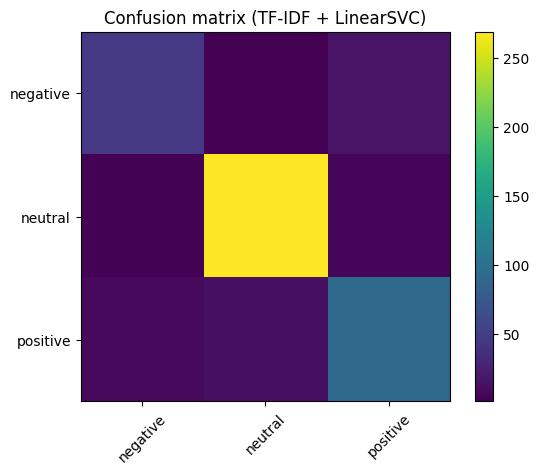

In [27]:
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion matrix (TF‑IDF + LinearSVC)")
plt.xticks(range(len(label_names)), label_names, rotation=45)
plt.yticks(range(len(label_names)), label_names)
plt.colorbar()
plt.show()


💡 **Мини‑практика (5 минут):**

1) Поменяйте `ngram_range=(1,1)` → `(1,2)` и сравните качество.
2) Поиграйте с `min_df` (1, 2, 5). Что происходит с качеством и скоростью?
3) Попробуйте `max_features=20000` у `TfidfVectorizer`.


## 4) Word2Vec: статические эмбеддинги → doc‑vector

Теперь сделаем то, что вы проходили раньше:
- обучим **Word2Vec** на нашем корпусе
- соберём вектор документа (предложения) как **усреднение** векторов слов
- обучим сверху простой классификатор

⚠️ Важно: датасет небольшой, Word2Vec тут — скорее **демонстрация механики**, а не SOTA.


In [28]:
from gensim.models import Word2Vec

# токенизируем
tokens = [simple_tokenize(t) for t in df["text"].values]

w2v = Word2Vec(
    sentences=tokens,
    vector_size=100,
    window=5,
    min_count=2,
    workers=2,
    sg=1,  # 1=skip-gram, 0=cbow
    negative=10,
    seed=42,
    epochs=20
)

("profit" in w2v.wv), len(w2v.wv)


(True, 2576)

In [29]:
# Посмотрим «похожие слова»
for w in ["profit", "loss", "market", "shares"]:
    if w in w2v.wv:
        print("\n", w, "->", w2v.wv.most_similar(w, topn=5))



 profit -> [('loss', 0.8671387434005737), ('turnover', 0.8089900612831116), ('ebit', 0.8059854507446289), ('swing', 0.7984909415245056), ('moved', 0.791824996471405)]

 loss -> [('profit', 0.8671388626098633), ('moved', 0.825511634349823), ('narrowed', 0.8214458227157593), ('swing', 0.8094268441200256), ('slipped', 0.7942439913749695)]

 market -> [('analysis', 0.7358233332633972), ('pharmaceutical', 0.7047379016876221), ('recently', 0.6847366094589233), ('cola', 0.6821712851524353), ('volkswagen', 0.6816012263298035)]

 shares -> [('rights', 0.7966302633285522), ('voting', 0.7641521692276001), ('number', 0.7463939785957336), ('series', 0.7361166477203369), ('outstanding', 0.7357823848724365)]


In [30]:
# doc-vector: усреднение векторов слов, которых мы знаем
def doc_vector_avg(text: str, model: Word2Vec):
    toks = simple_tokenize(text)
    vecs = [model.wv[w] for w in toks if w in model.wv]
    if not vecs:
        return np.zeros(model.vector_size, dtype=np.float32)
    return np.mean(vecs, axis=0)

X_w2v = np.vstack([doc_vector_avg(t, w2v) for t in df["text"].values])
X_w2v.shape


(2264, 100)

In [31]:
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(
    X_w2v, df["label"].values, test_size=0.2, random_state=42, stratify=df["label"].values
)

w2v_lr = LogisticRegression(max_iter=2000)
w2v_lr.fit(X_train_w2v, y_train_w2v)

pred_w2v = w2v_lr.predict(X_test_w2v)
print(classification_report(y_test_w2v, pred_w2v, target_names=label_names))


              precision    recall  f1-score   support

    negative       0.70      0.31      0.43        61
     neutral       0.89      0.93      0.91       278
    positive       0.59      0.69      0.64       114

    accuracy                           0.79       453
   macro avg       0.73      0.65      0.66       453
weighted avg       0.79      0.79      0.78       453



Вот аккуратный блок, который можно вставить в ноутбук как Markdown-ячейку перед BERT.

---

## 5.0) Токенизация в BERT и специальные токены (справка)

### Зачем вообще токенизация?

Модель не работает напрямую со строками.
Текст проходит три шага:

```
текст → токены → id → эмбеддинги
```
Вот максимально короткая версия — только идея и простой пример.

---

## Как обучаются токенизаторы (на примере)

Токенизатор учится находить **часто встречающиеся куски слов**, чтобы сделать словарь компактным.

### Пример корпуса

```
low
lower
lowest
```

### Шаг 1 — начинаем с символов

```
l o w
l o w e r
l o w e s t
```

### Шаг 2 — считаем частые пары

Чаще всего встречается `l o` и `lo w`

Объединяем:

```
lo w
lo w e r
lo w e s t
```

### Шаг 3 — дальше объединяем `lo` + `w` → `low`

```
low
low e r
low e s t
```

### Шаг 4 — объединяем `e r` → `er`

```
low
low er
low e s t
```

И так продолжаем, пока словарь не достигнет нужного размера.

---

## Что получается

Словарь может стать таким:

```
low
er
est
```

Тогда:

```
lowest → low + est
lower  → low + er
```

---

## Очень коротко

> Токенизатор обучается, объединяя самые частые куски текста в подслова.

---

Если нужно, могу так же коротко показать, как WordPiece добавляет `##` для продолжений слова.

BERT использует **WordPiece-токенизацию** — это подсловный алгоритм.

---



### WordPiece (идея)

Если слово есть в словаре — берём его целиком.
Если нет — разбиваем на подслова.

Пример:

```
unbelievable → un ##bel ##ievable
```

* `##` означает, что это продолжение слова.
* Это позволяет:

  * уменьшить размер словаря
  * работать с редкими словами
  * обрабатывать новые слова

---

## Специальные токены в BERT

BERT имеет набор технических токенов, которые используются в обучении и инференсе.

### 1) `[CLS]` — classification token

* Добавляется **в начало** последовательности.
* Его скрытое состояние (последнего слоя) часто используют как представление всего текста.
* Пример:

```
[CLS] profit rises today
```

---

### 2) `[SEP]` — separator

* Разделяет предложения.
* Используется в задачах “пара предложений”.

Пример:

```
[CLS] sentence A [SEP] sentence B [SEP]
```

---

### 3) `[PAD]` — padding

* Добавляется для выравнивания длины в батче.
* Не несёт смысла.
* Игнорируется через **attention mask**.

---

### 4) `[MASK]` — маскированный токен

* Используется при предобучении BERT.
* Модель должна угадать скрытое слово.

Пример (MLM):

```
profit [MASK] today
```

---

### 5) `[UNK]` — unknown

* Если токенизатор не может разбить слово, используется `[UNK]`.
* В современных моделях встречается редко (из-за подсловной токенизации).

---

## Что реально подаётся в модель

После токенизации формируются три набора входов:

* `input_ids` — индексы токенов
* `attention_mask` — где 1 = реальный токен, 0 = PAD
* `token_type_ids` — номер сегмента (0 или 1)

Именно они поступают в Transformer Encoder.


In [46]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

text = "Profit rises today"
enc = tokenizer(text)

print("Tokens:", tokenizer.convert_ids_to_tokens(enc["input_ids"]))
print("Input IDs:", enc["input_ids"])



Tokens: ['[CLS]', 'profit', 'rises', 'today', '[SEP]']
Input IDs: [101, 5618, 9466, 2651, 102]



Типичный вывод:

```
['[CLS]', 'profit', 'rises', 'today', '[SEP]']
```

---

## Мини-вывод

* BERT работает не со словами, а с **подсловными токенами**.
* Специальные токены помогают:

  * агрегировать информацию (`[CLS]`)
  * разделять предложения (`[SEP]`)
  * маскировать слова для обучения (`[MASK]`)
  * корректно работать с батчами (`[PAD]`)

---

Если хочешь, могу сделать ещё маленькую таблицу “что участвует только в обучении, а что используется всегда” — это часто вызывает вопросы у студентов.


💡 **Пара комментариев:**

- В Word2Vec у слова **один** вектор на все контексты → «bank (finance)» и «bank (river)» будут смешиваться.
- Усреднение по словам теряет порядок и отрицания.
- Но как baseline и как «векторизация» — очень полезно, и часто быстрее TF‑IDF на некоторых задачах.


## 5) Зачем перед BERT разбирать Attention/Transformer (мини-справка)

До трансформеров в NLP часто брали **статические** эмбеддинги (Word2Vec/fastText):
одно слово → один вектор, **контекст не меняет** представление.
Трансформер делает следующий шаг: он строит **контекстные** представления — каждый токен получает вектор, зависящий от окружения.

### Интуиция self-attention

Self-attention отвечает на вопрос:

> “На какие слова в предложении мне смотреть, чтобы лучше понять текущий токен?”

То есть это **взвешенное суммирование** значимых токенов, где веса вычисляются автоматически.

### Формула scaled dot-product attention

Пусть вход — матрица токеновых представлений `X` размера `(seq_len × d_model)`.
Мы строим три проекции:

$$
Q = XW_Q,\quad K = XW_K,\quad V = XW_V
$$

Далее считаем “оценки похожести” (scores) между запросами и ключами и нормируем их softmax’ом:

$$
\mathrm{Attention}(Q, K, V)=
\mathrm{softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right)V
$$

* **`X`** — входные представления токенов (embedding каждого токена до attention).
  Размер: `seq_len × d_model`.

* **`W_Q, W_K, W_V`** — обучаемые матрицы весов (параметры слоя), которые “переупаковывают” `X` в три разных пространства.
  Обычно размер: `d_model × d_k` (или `d_model × d_head` для одной головы).

* **`Q` (Query, “запрос”)** — векторы, которые задают: *“что я ищу в других токенах?”*
  Используется как “кто спрашивает”.

* **`K` (Key, “ключ”)** — векторы, которые задают: *“по каким признакам меня можно найти?”*
  Используется как “по чему сравниваем”.

* **`V` (Value, “значение”)** — векторы с содержимым, которое мы реально будем смешивать и переносить дальше.
  Это “что забираем” после того, как решили, на кого смотреть.

* **`QKᵀ`** — матрица “оценок внимания” (scores): насколько каждый токен (через Q) похож/релевантен каждому токену (через K).
  Размер: `seq_len × seq_len`.

* **`/ √d_k`** — масштабирование, чтобы scores не становились слишком большими при больших размерностях (иначе softmax будет “слишком резкий”).

* **`softmax(...)`** — превращает scores в вероятности по строкам: для каждого токена получаем распределение весов, сумма = 1.

* **`softmax(...) · V`** — взвешенная сумма value-векторов: новый контекстный вектор для каждого токена.
  Размер результата: `seq_len × d_k`.

Если хочешь супер-короткую метафору:

> Q — “что хочу найти”, K — “как меня находят”, V — “что во мне полезного взять”.

### Attention mask: почему он нужен

В батче предложения имеют разную длину, поэтому мы дополняем их токеном `[PAD]`.
Но `[PAD]` не несёт смысла — он **не должен** получать внимание.

Поэтому перед softmax мы добавляем маску:

$$
\mathrm{softmax}\left(\frac{QK^\top + M}{\sqrt{d_k}}\right)
$$

где `M` — матрица, в которой:

* `0` для нормальных позиций,
* `-∞` (или очень большое отрицательное число) для паддингов.

Тогда после softmax веса на `[PAD]` становятся ≈ 0.


### 5.1 Self‑attention «вручную» на PyTorch

Мы сделаем *игрушечный* пример:
- есть 4 «токена» с эмбеддингами
- считаем Q/K/V и матрицу внимания
- добавим padding‑mask (закрываем последний токен)


In [42]:
import math
import torch

torch.manual_seed(42)

# ============================================================
# 1) Вход X: "токеновые представления" (до attention)
#    4 токена, размерность d_model=6
#    X[i] — вектор i-го токена
# ============================================================
X = torch.randn(4, 6)  # shape: (n_tokens=4, d_model=6)

# ============================================================
# 2) Обучаемые матрицы Wq/Wk/Wv: проекции из d_model -> d_k
#    В реальной модели эти матрицы учатся градиентным спуском
# ============================================================
Wq = torch.randn(6, 4)  # shape: (6, 4)
Wk = torch.randn(6, 4)
Wv = torch.randn(6, 4)

# ============================================================
# 3) Q, K, V: проекции входа
#    Q — "что я ищу", K — "по чему меня находят", V — "что я отдаю"
# ============================================================
Q = X @ Wq  # (4,4)
K = X @ Wk  # (4,4)
V = X @ Wv  # (4,4)

dk = Q.shape[-1]

# ============================================================
# 4) scores = QK^T / sqrt(dk)
#    scores[i, j] — насколько токен i "смотрит" на токен j
#    (больше => выше внимание после softmax)
# ============================================================
scores = (Q @ K.T) / math.sqrt(dk)  # shape: (4,4)

print("X:", X.shape, "Q:", Q.shape, "K:", K.shape, "V:", V.shape, "scores:", scores.shape)
scores

X: torch.Size([4, 6]) Q: torch.Size([4, 4]) K: torch.Size([4, 4]) V: torch.Size([4, 4]) scores: torch.Size([4, 4])


tensor([[-10.9066,  -2.9388,  -3.0906,  -3.9318],
        [ -3.8093,   0.6389,  -1.6450,  -1.0963],
        [ 11.4249,   2.8401,  -1.4600,   1.9964],
        [  2.8590,   1.3153,  -1.0943,   0.4096]])

In [43]:
# ============================================================
# 5) softmax по строкам => attention weights A
#    A[i, :] — распределение внимания токена i по всем токенам j
#    сумма по строке = 1
# ============================================================
def softmax(x, dim=-1):
    x = x - x.max(dim=dim, keepdim=True).values  # стабильность
    return torch.exp(x) / torch.exp(x).sum(dim=dim, keepdim=True)

A = softmax(scores, dim=-1)  # shape: (4,4)

# ============================================================
# 6) out = A @ V
#    out[i] — новый "контекстный" вектор токена i:
#    это взвешенная сумма V[j] с весами A[i,j]
# ============================================================
out = A @ V  # shape: (4,4)

# Быстрые проверки/интерпретация:
print("A row sums:", A.sum(dim=1))            # должно быть ~1
print("For token 0, top attended token:", int(A[0].argmax()))
A, out

A row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000])
For token 0, top attended token: 1


(tensor([[1.5536e-04, 4.4843e-01, 3.8529e-01, 1.6613e-01],
         [9.0694e-03, 7.7523e-01, 7.8982e-02, 1.3672e-01],
         [9.9973e-01, 1.8689e-04, 2.5353e-06, 8.0382e-05],
         [7.5808e-01, 1.6192e-01, 1.4547e-02, 6.5456e-02]]),
 tensor([[-0.2238, -1.2635, -0.7026, -1.7696],
         [-1.4965, -0.9477,  1.2324, -0.4824],
         [ 4.6100,  1.6961,  5.2503,  0.2836],
         [ 3.1693,  1.0032,  4.2458,  0.0444]]))

In [44]:
# ============================================================
# 7) Padding mask: запрещаем смотреть на [PAD]
#    Пусть токен 3 (четвертый) = [PAD], на него внимание должно стать ~0
#    mask[j] = 1 если токен реальный, 0 если PAD
# ============================================================
mask = torch.tensor([1, 1, 1, 0], dtype=torch.float32)  # shape: (4,)

# ============================================================
# 8) Как делается mask в attention:
#    к scores добавляют большой отрицательный штраф в "запрещенные" столбцы (куда смотрим)
#    => после softmax внимание на PAD ~ 0
# ============================================================
M = (1 - mask)[None, :] * (-1e9)  # shape: (1,4), будет broadcast на (4,4)
scores_masked = scores + M

A_masked = softmax(scores_masked, dim=-1)
out_masked = A_masked @ V

# Проверим: внимание на PAD-столбец (j=3) стало ~0 во всех строках
print("Attention to PAD column before:", A[:, 3])
print("Attention to PAD column after :", A_masked[:, 3])

A_masked

Attention to PAD column before: tensor([1.6613e-01, 1.3672e-01, 8.0382e-05, 6.5456e-02])
Attention to PAD column after : tensor([0., 0., 0., 0.])


tensor([[1.8631e-04, 5.3777e-01, 4.6205e-01, 0.0000e+00],
        [1.0506e-02, 8.9800e-01, 9.1490e-02, 0.0000e+00],
        [9.9981e-01, 1.8690e-04, 2.5355e-06, 0.0000e+00],
        [8.1118e-01, 1.7326e-01, 1.5566e-02, 0.0000e+00]])

In [45]:
# "Куда больше всего смотрит токен i?"
for i in range(4):
    print(i, "->", int(A_masked[i].argmax()), "weights:", A_masked[i].tolist())

0 -> 1 weights: [0.00018630907288752496, 0.5377665758132935, 0.46204712986946106, 0.0]
1 -> 1 weights: [0.01050571259111166, 0.8980041742324829, 0.09149017184972763, 0.0]
2 -> 0 weights: [0.9998106360435486, 0.00018690465367399156, 2.5355452635267284e-06, 0.0]
3 -> 0 weights: [0.8111752867698669, 0.17325833439826965, 0.015566330403089523, 0.0]


💡 Тут вы руками увидели, что такое `attention_mask`:
- без маски модель может «разговаривать» с [PAD]
- с маской веса на [PAD] становятся ≈ 0

В ваших слайдах это же записано как добавление матрицы M перед softmax. fileciteturn1file0L2-L16


## 6) BERT для классификации: два режима

1) **Feature-based**: BERT замораживаем, берём эмбеддинг текста и обучаем сверху простую модель.
2) **Fine-tuning**: дообучаем BERT вместе с классификационной «головой».

Это ровно две стратегии, которые вы обсуждали на лекции. fileciteturn1file0L43-L52


### 6.1 Подготовка: токенизация

Мы возьмём доменную модель **FinBERT** (BERT, дообученный на финансовых текстах).
Если хочется максимально быстро — можно заменить на `distilbert-base-uncased`.


In [35]:
from transformers import AutoTokenizer, AutoModel
import torch

MODEL_NAME = "ProsusAI/finbert"  # доменная модель для финансовой тональности
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Проверка токенизации
sample = df["text"].iloc[0]
print("TEXT:", sample)
enc = tokenizer(sample, truncation=True, padding="max_length", max_length=32, return_tensors="pt")
{k: v.shape for k,v in enc.items()}


TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


{'input_ids': torch.Size([1, 32]),
 'token_type_ids': torch.Size([1, 32]),
 'attention_mask': torch.Size([1, 32])}

In [36]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

### 6.2 Feature-based: эмбеддинги текста → LogisticRegression

Сделаем так:
- берём `AutoModel` (без классификационной головы)
- достаём эмбеддинг `[CLS]` (первый токен)
- учим сверху `LogisticRegression`

⚠️ Это быстрее, чем fine-tuning, и часто хороший baseline.
[CLS] как «сводка» для классификации упоминается в лекции. fileciteturn1file0L48-L49


In [37]:
from transformers import AutoModel
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

bert_backbone = AutoModel.from_pretrained(MODEL_NAME).to(device)
bert_backbone.eval()

@torch.no_grad()
def cls_embeddings(texts, batch_size=32, max_length=64):
    all_vecs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(
            list(batch),
            truncation=True,
            padding=True,
            max_length=max_length,
            return_tensors="pt"
        ).to(device)
        out = bert_backbone(**enc)
        # last_hidden_state: (B, T, H). CLS - это позиция 0.
        cls = out.last_hidden_state[:, 0, :].detach().cpu().numpy()
        all_vecs.append(cls)
    return np.vstack(all_vecs)

# Чтобы было быстрее на семинаре: можно ограничиться подмножеством
N = len(df)  # поменяйте, например, на 1200 чтобы ускорить
texts_small = df["text"].values[:N]
labels_small = df["label"].values[:N]

X_emb = cls_embeddings(texts_small, batch_size=32, max_length=64)
X_emb.shape


(2264, 768)

In [38]:
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(
    X_emb, labels_small, test_size=0.2, random_state=42, stratify=labels_small
)

emb_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])

emb_lr.fit(X_train_e, y_train_e)
pred_emb = emb_lr.predict(X_test_e)

print(classification_report(y_test_e, pred_emb, target_names=label_names))


              precision    recall  f1-score   support

    negative       0.98      0.97      0.98        61
     neutral       1.00      0.99      1.00       278
    positive       0.97      0.99      0.98       114

    accuracy                           0.99       453
   macro avg       0.98      0.98      0.98       453
weighted avg       0.99      0.99      0.99       453



### 6.3 Fine-tuning: простой PyTorch‑цикл обучения

Теперь «честный» fine‑tuning:
- берём `AutoModelForSequenceClassification`
- оптимизируем кросс‑энтропию

⚠️ Важно:
- на CPU может быть медленно → лучше GPU
- для семинара оставим 1 эпоху и/или подмножество


In [40]:
# ====== imports ======
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import AutoModelForSequenceClassification

# предполагается, что у тебя уже есть:
# df (с колонками "text", "label"), tokenizer, MODEL_NAME, label_names, device

# ====== dataset ======
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=96):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        t = self.texts[idx]
        y = int(self.labels[idx])

        enc = self.tokenizer(
            t,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(y, dtype=torch.long)
        return item

# ====== data split ======
N_FT = len(df)  # например: 1500 для скорости
texts_ft = df["text"].values[:N_FT]
labels_ft = df["label"].values[:N_FT]

X_train_t, X_val_t, y_train_t, y_val_t = train_test_split(
    texts_ft,
    labels_ft,
    test_size=0.2,
    random_state=42,
    stratify=labels_ft
)

train_ds = TextDataset(X_train_t, y_train_t, tokenizer, max_length=96)
val_ds   = TextDataset(X_val_t,   y_val_t,   tokenizer, max_length=96)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False)

# ====== model + optimizer ======
model_ft = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_names)
).to(device)

opt = AdamW(model_ft.parameters(), lr=2e-5)

# ====== train/eval loop ======
def run_epoch(model, loader, optimizer=None):
    train_mode = optimizer is not None
    model.train() if train_mode else model.eval()

    losses, all_pred, all_true = [], [], []

    for batch in loader:
        batch = {k: v.to(device) for k, v in batch.items()}

        if train_mode:
            out = model(**batch)
            loss = out.loss
            logits = out.logits

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()
        else:
            with torch.no_grad():
                out = model(**batch)
                loss = out.loss
                logits = out.logits

        losses.append(loss.item())
        all_pred.append(logits.detach().cpu().numpy())
        all_true.append(batch["labels"].detach().cpu().numpy())

    all_pred = np.argmax(np.vstack(all_pred), axis=1)
    all_true = np.concatenate(all_true)
    return float(np.mean(losses)), all_true, all_pred

# ====== 1 epoch ======
train_loss, _, _ = run_epoch(model_ft, train_loader, optimizer=opt)
val_loss, y_true, y_pred = run_epoch(model_ft, val_loader, optimizer=None)

print("train_loss:", train_loss, "val_loss:", val_loss)
print(classification_report(y_true, y_pred, target_names=label_names))

train_loss: 0.594436059852964 val_loss: 0.1457632506887118
              precision    recall  f1-score   support

    negative       0.92      0.74      0.82        61
     neutral       1.00      1.00      1.00       278
    positive       0.87      0.96      0.91       114

    accuracy                           0.95       453
   macro avg       0.93      0.90      0.91       453
weighted avg       0.95      0.95      0.95       453



## 7) Итоговое сравнение методов

Соберём таблицу с метриками (macro‑F1 и accuracy).
В реальном проекте добавляют ещё скорость, размер модели, интерпретируемость.


In [41]:
from sklearn.metrics import f1_score, accuracy_score

def metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "macro_f1": f1_score(y_true, y_pred, average="macro")
    }

rows = []

rows.append({"method":"TF‑IDF + LR", **metrics(y_test, pred_lr)})
rows.append({"method":"TF‑IDF + LinearSVC", **metrics(y_test, pred_svm)})
rows.append({"method":"Word2Vec(avg) + LR", **metrics(y_test_w2v, pred_w2v)})
rows.append({"method":"BERT CLS (feature‑based) + LR", **metrics(y_test_e, pred_emb)})
rows.append({"method":"BERT fine‑tuning (1 epoch)", **metrics(y_true, y_pred)})

res = pd.DataFrame(rows).sort_values("macro_f1", ascending=False)
res


,method,accuracy,macro_f1
3,BERT CLS (feature‑based) + LR,0.988962,0.983317
4,BERT fine‑tuning (1 epoch),0.951435,0.907639
1,TF‑IDF + LinearSVC,0.900662,0.850302
0,TF‑IDF + LR,0.832230,0.741773
2,Word2Vec(avg) + LR,0.788079,0.659229
